In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, fbeta_score, roc_curve, roc_auc_score, plot_roc_curve


In [2]:
df = pd.read_csv('UAH-DRIVESET-classification.csv', index_col=0)
df.head()

,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,road_type,class_normal,temp_F,humidity_pct,wind_speed_mph,wind_gust_mph,condition,day_night,speed_mph,class_normal_bool
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.955226,0
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.099995,0
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.018755,0
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.811020,0
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,37.524521,0


In [3]:
df['road_type_dummy'] = pd.get_dummies(df['road_type'], drop_first=True)


In [4]:
df['night_dummy'] = pd.get_dummies(df['day_night'], drop_first=True)
df.head()


,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,road_type,class_normal,temp_F,humidity_pct,wind_speed_mph,wind_gust_mph,condition,day_night,speed_mph,class_normal_bool,road_type_dummy,night_dummy
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.955226,0,1,1
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.099995,0,1,1
2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,40.018755,0,1,1
3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,38.811020,0,1,1
4,100.0,100.0,100.0,100.0,100.0,100.0,100.0,SECONDARY,NORMAL,72,35,2,0,Fair,Night,37.524521,0,1,1


# Sub-sample the data for base models, select features, determine classification metric (F2)

In [5]:
df_sub = df.sample(n=15000, random_state=42)


In [6]:
X = df_sub.drop(['class_normal_bool'], axis=1)
y = df_sub['class_normal_bool']


In [7]:
X_train, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_all, X_val_all, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train_all[['acceleration_score', 'braking_score', 'speeding_score']]
X_val = X_val_all[['acceleration_score', 'braking_score', 'speeding_score']]
X_test = X_test_all[['acceleration_score', 'braking_score', 'speeding_score']]


In [8]:
X_train.shape, y_train.shape

((9000, 3), (9000,))

In [9]:
fbeta_scorer = make_scorer(fbeta_score, beta=2)

# KNN

In [10]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.transform(X_val)
X_test_scaled = std_scale.transform(X_test)


In [11]:
k_range = list(range(3, 151, 2))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train_scaled, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


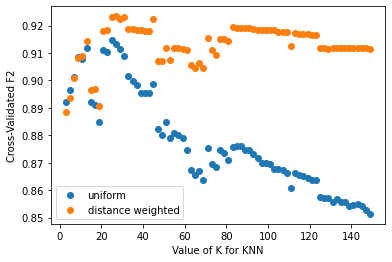

In [12]:
plt.scatter(df_cv[df_cv.param_weights == 'uniform'].param_n_neighbors, df_cv[df_cv.param_weights == 'uniform'].mean_test_score, label='uniform')
plt.scatter(df_cv[df_cv.param_weights == 'distance'].param_n_neighbors, df_cv[df_cv.param_weights == 'distance'].mean_test_score, label='distance weighted')

plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [13]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'n_neighbors': 27, 'weights': 'distance'}
Best estimator:  KNeighborsClassifier(n_neighbors=27, weights='distance')
Best score:  0.9233969886666547


# Logit

Cross-val logit

In [14]:
C_range = list(np.logspace(-5, 3, 200))

param_grid = dict(C=C_range)

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train_scaled, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


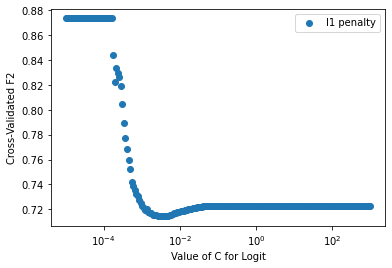

In [15]:
plt.scatter(df_cv.param_C, df_cv.mean_test_score, label='l1 penalty')

plt.xlabel('Value of C for Logit')
plt.ylabel('Cross-Validated F2')

plt.xscale('log')
plt.legend();


In [16]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'C': 1e-05}
Best estimator:  LogisticRegression(C=1e-05)
Best score:  0.8735946459635333


# Decision Tree

In [17]:
max_depth_range = list(range(1,21))
criterion_options = ['entropy', 'gini']
min_samples_split_range = list(range(2,11))
min_samples_leaf_range = list(range(1,6))

param_grid = dict(max_depth=max_depth_range, criterion=criterion_options,
                  min_samples_split=min_samples_split_range, min_samples_leaf=min_samples_leaf_range)

decisiontree = DecisionTreeClassifier()
grid = GridSearchCV(decisiontree, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


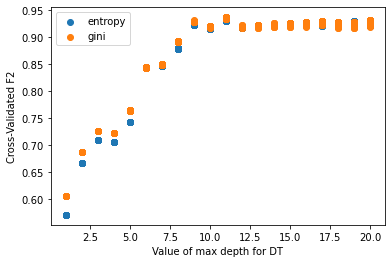

In [18]:
plt.scatter(df_cv[df_cv.param_criterion == 'entropy'].param_max_depth, df_cv[df_cv.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv[df_cv.param_criterion == 'gini'].param_max_depth, df_cv[df_cv.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for DT')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [19]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best estimator:  DecisionTreeClassifier(max_depth=11, min_samples_split=10)
Best score:  0.937309180001173


# Random Forest

In [20]:
max_features_options = ['sqrt', 'log2', 'auto']
criterion_options = ['entropy', 'gini']

param_grid = dict(max_features=max_features_options, criterion=criterion_options)

rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

grid.fit(X_train, y_train)

df_cv = pd.DataFrame(grid.cv_results_)


In [21]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)


Best params:  {'criterion': 'gini', 'max_features': 'sqrt'}
Best estimator:  RandomForestClassifier(max_features='sqrt')
Best score:  0.9346135539131979


**Notes:**

- Used 3 features: acceleration, braking, speeding
- Logistic Regression (F2 score < 0.9) does not perform as well as the other models (all have F2 scores > 0.9)
    - Likely non-linear decision boundary required for classification
    - Models that can have non-linear decision boundaries (e.g., decision tree/ensemble models) will perform better
- Drop Logistic Regression from further consideration


# Add more features

In [22]:
X_train_all.columns

Index(['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
       'drifting_score', 'speeding_score', 'follow_score', 'road_type',
       'class_normal', 'temp_F', 'humidity_pct', 'wind_speed_mph',
       'wind_gust_mph', 'condition', 'day_night', 'speed_mph',
       'road_type_dummy', 'night_dummy'],
      dtype='object')

In [23]:
X_train = X_train_all[['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
                       'drifting_score', 'speeding_score', 'follow_score', 'speed_mph', 
                       'road_type_dummy', 'night_dummy']]
X_val = X_val_all[['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
                   'drifting_score', 'speeding_score', 'follow_score', 'speed_mph', 
                   'road_type_dummy', 'night_dummy']]
X_test = X_test_all[['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
                   'drifting_score', 'speeding_score', 'follow_score', 'speed_mph', 
                   'road_type_dummy', 'night_dummy']]


In [24]:
X_train.shape, y_train.shape

((9000, 10), (9000,))

# KNN (with more features)

In [25]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.transform(X_val)
X_test_scaled = std_scale.transform(X_test)


In [26]:
k_range = list(range(3, 151, 2))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

knn_grid.fit(X_train_scaled, y_train)

df_cv_knn = pd.DataFrame(knn_grid.cv_results_)


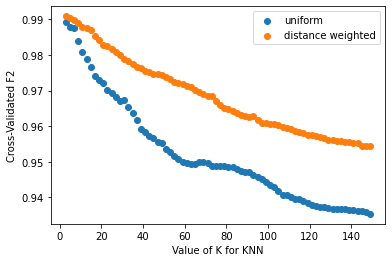

In [27]:
plt.scatter(df_cv_knn[df_cv_knn.param_weights == 'uniform'].param_n_neighbors, df_cv_knn[df_cv_knn.param_weights == 'uniform'].mean_test_score, label='uniform')
plt.scatter(df_cv_knn[df_cv_knn.param_weights == 'distance'].param_n_neighbors, df_cv_knn[df_cv_knn.param_weights == 'distance'].mean_test_score, label='distance weighted')

plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [28]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)


Best params:  {'n_neighbors': 3, 'weights': 'distance'}
Best estimator:  KNeighborsClassifier(n_neighbors=3, weights='distance')
Best score:  0.9908809084234242


In [29]:
knn = KNeighborsClassifier(n_neighbors=knn_grid.best_params_['n_neighbors'], weights='distance')
knn.fit(X_train_scaled, y_train)

y_knn_pred = knn.predict(X_val_scaled)
y_knn_pred_prob = knn.predict_proba(X_val_scaled)[:, 1]

print(f'Accuracy:\t {accuracy_score(y_val, y_knn_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_knn_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_knn_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_knn_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_knn_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_knn_pred):.4f}')


Accuracy:	 0.9907
Precision:	 0.9948
Recall:		 0.9891
F1:		 0.9920
Fbeta (beta=2):	 0.9903
AUC:		 0.9910


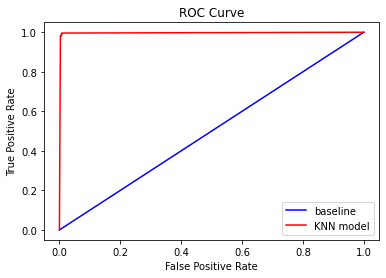

In [30]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_knn_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'KNN model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend();


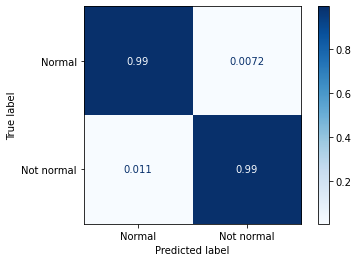

In [31]:
plot_confusion_matrix(knn, X_val_scaled, y_val,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true')


# Decision Tree (with more features)

In [32]:
max_depth_range = list(range(10,36))
criterion_options = ['entropy', 'gini']

param_grid = dict(max_depth=max_depth_range, criterion=criterion_options)

decisiontree = DecisionTreeClassifier()
dt_grid = GridSearchCV(decisiontree, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

dt_grid.fit(X_train, y_train)

df_cv_dt = pd.DataFrame(dt_grid.cv_results_)


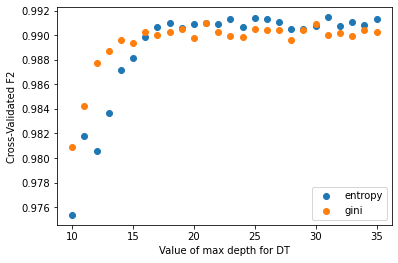

In [33]:
plt.scatter(df_cv_dt[df_cv_dt.param_criterion == 'entropy'].param_max_depth, df_cv_dt[df_cv_dt.param_criterion == 'entropy'].mean_test_score, label='entropy')
plt.scatter(df_cv_dt[df_cv_dt.param_criterion == 'gini'].param_max_depth, df_cv_dt[df_cv_dt.param_criterion == 'gini'].mean_test_score, label='gini')

plt.xlabel('Value of max depth for DT')
plt.ylabel('Cross-Validated F2')

plt.legend();


In [34]:
print("Best params: ", dt_grid.best_params_)
print("Best estimator: ", dt_grid.best_estimator_)
print("Best score: ", dt_grid.best_score_)


Best params:  {'criterion': 'entropy', 'max_depth': 31}
Best estimator:  DecisionTreeClassifier(criterion='entropy', max_depth=31)
Best score:  0.9914612014056894


In [35]:
dt = DecisionTreeClassifier(criterion=dt_grid.best_params_['criterion'], max_depth=dt_grid.best_params_['max_depth'])
dt.fit(X_train, y_train)

y_dt_pred = dt.predict(X_val)
y_dt_pred_prob = dt.predict_proba(X_val)[:, 1]


print(f'Accuracy:\t {accuracy_score(y_val, y_dt_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_dt_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_dt_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_dt_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_dt_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_dt_pred):.4f}')


Accuracy:	 0.9880
Precision:	 0.9908
Recall:		 0.9886
F1:		 0.9897
Fbeta (beta=2):	 0.9890
AUC:		 0.9879


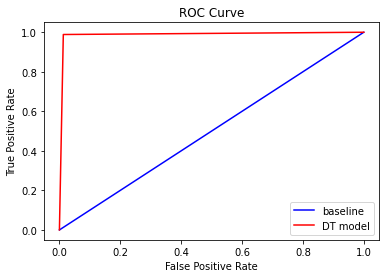

In [36]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_dt_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'DT model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend();


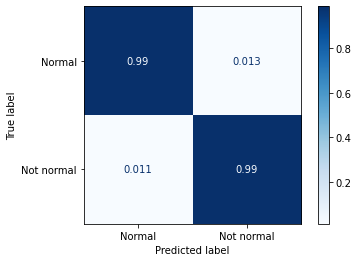

In [37]:
plot_confusion_matrix(dt, X_val, y_val,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true')


# Random Forest (with more features)

In [38]:
max_features_options = ['sqrt', 'log2', 'auto']
criterion_options = ['entropy', 'gini']

param_grid = dict(max_features=max_features_options, criterion=criterion_options)

rf = RandomForestClassifier(bootstrap=True)
rf_grid = GridSearchCV(rf, param_grid, cv=10, scoring=fbeta_scorer, n_jobs=-1)

rf_grid.fit(X_train, y_train)

df_cv_rf = pd.DataFrame(rf_grid.cv_results_)


In [39]:
print("Best params: ", rf_grid.best_params_)
print("Best estimator: ", rf_grid.best_estimator_)
print("Best score: ", rf_grid.best_score_)


Best params:  {'criterion': 'gini', 'max_features': 'log2'}
Best estimator:  RandomForestClassifier(max_features='log2')
Best score:  0.9938323666036778


In [40]:
rf = RandomForestClassifier(max_features=rf_grid.best_params_['max_features'], bootstrap=True)
rf.fit(X_train, y_train)

y_rf_pred = rf.predict(X_val)
y_rf_pred_prob = rf.predict_proba(X_val)[:, 1]

print(f'Accuracy:\t {accuracy_score(y_val, y_rf_pred):.4f}')
print(f'Precision:\t {precision_score(y_val, y_rf_pred):.4f}')
print(f'Recall:\t\t {recall_score(y_val, y_rf_pred):.4f}')
print(f'F1:\t\t {f1_score(y_val, y_rf_pred):.4f}')
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, y_rf_pred, beta=2):.4f}')
print(f'AUC:\t\t {roc_auc_score(y_val, y_rf_pred):.4f}')


Accuracy:	 0.9910
Precision:	 0.9937
Recall:		 0.9909
F1:		 0.9923
Fbeta (beta=2):	 0.9914
AUC:		 0.9910


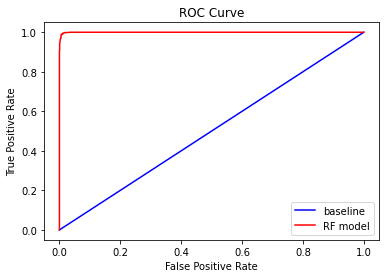

In [41]:
base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
model_fpr, model_tpr, _ = roc_curve(y_val, y_rf_pred_prob)

plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'RF model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.legend();


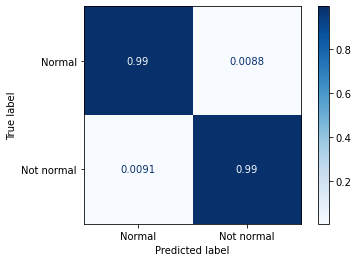

In [42]:
plot_confusion_matrix(rf, X_val, y_val,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true')


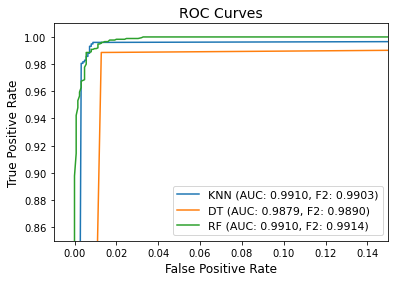

In [43]:
labels = ['KNN', 'DT', 'RF']
y_preds = [y_knn_pred, y_dt_pred, y_rf_pred]
for i,probs in enumerate([y_knn_pred_prob, y_dt_pred_prob, y_rf_pred_prob]):
    base_fpr, base_tpr, _ = roc_curve(y_val, [1 for _ in range(len(y_val))])
    model_fpr, model_tpr, _ = roc_curve(y_val, probs)

    plt.plot(model_fpr, model_tpr, label = f'{labels[i]} (AUC: {roc_auc_score(y_val, y_preds[i]):.4f}, F2: {fbeta_score(y_val, y_preds[i], beta=2):.4f})')

#plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.title('ROC Curves', fontsize=14)

plt.xlim(-0.01,0.15)
plt.ylim(0.85,1.01)

plt.legend(fontsize=11)

plt.savefig('figures/roc_curves_base.png', dpi=300);


**Notes:**

- RF performs slightly better than DT and KNN models on the validation set (F2 score)
- Predictions with KNN will be very slow
    - Want to use the model in real-time during a driving session, so slow predictions will be problematic
- DT is slightly overfit to the training data
- Will also test an XGBoost model on these features

# XGBoost (with more features)

In [44]:
import xgboost as xgb


In [45]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000, #arbitrary large number
                        max_depth=4,
                        objective='binary:logistic',  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                        learning_rate=0.1, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=0.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False #gives output log as below
                   )


/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [46]:
print(f'Fbeta (beta=2):\t {fbeta_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit), beta=2):.4f}')


Fbeta (beta=2):	 0.9922


/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Notes:
- Out of the box (minimal tuning of max depth), XGBoost already out-performs Random Forest on the validation set
- However, tuning XGBoost will be time consuming; can use GridSearchCV for Random Forest
- Choosing Randfom Forest classifier as final model

# Random Forest model tuning

In [47]:
from tqdm import tqdm

In [48]:
oob_error_sqrt = []
for i in tqdm(range(10, 300 + 1)):
        rf = RandomForestClassifier(n_estimators=i, warm_start=True, oob_score=True, max_features='sqrt', bootstrap=True, n_jobs=-1)
        rf.fit(X_train, y_train)

        oob_error_sqrt.append(1.0 - rf.oob_score_)


  0%|          | 0/291 [00:00<?, ?it/s]/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
  0%|          | 1/291 [00:00<00:32,  9.06it/s]/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
  

In [49]:
oob_error_log2 = []
for i in tqdm(range(10, 300 + 1)):
        rf = RandomForestClassifier(n_estimators=i, warm_start=True, oob_score=True, max_features='log2', bootstrap=True, n_jobs=-1)
        rf.fit(X_train, y_train)

        oob_error_log2.append(1.0 - rf.oob_score_)


  0%|          | 0/291 [00:00<?, ?it/s]/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
  1%|          | 2/291 [00:00<00:25, 11.54it/s]/U

In [50]:
oob_error_auto = []
for i in tqdm(range(10, 300 + 1)):
        rf = RandomForestClassifier(n_estimators=i, warm_start=True, oob_score=True, max_features='auto', bootstrap=True, n_jobs=-1)
        rf.fit(X_train, y_train)

        oob_error_auto.append(1.0 - rf.oob_score_)
        

  0%|          | 0/291 [00:00<?, ?it/s]/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
  1%|          | 2/291 [00:00<00:18, 15.41it/s]/U

In [51]:
oob_error_none = []
for i in tqdm(range(10, 300 + 1)):
        rf = RandomForestClassifier(n_estimators=i, warm_start=True, oob_score=True, max_features=None, bootstrap=True, n_jobs=-1)
        rf.fit(X_train, y_train)

        oob_error_none.append(1.0 - rf.oob_score_)
        

  0%|          | 0/291 [00:00<?, ?it/s]/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
  0%|          | 1/291 [00:00<00:48,  6.01it/s]/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Hannah/anaconda/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
  

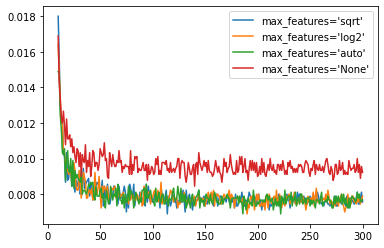

In [52]:
errors = [oob_error_sqrt, oob_error_log2, oob_error_auto, oob_error_none]
labels = ['sqrt', 'log2', 'auto', 'None']

for i,error in enumerate(errors):
    plt.plot(list(range(10, 300 + 1)), error, label=f"max_features='{labels[i]}'")

plt.legend();


Notes:
- Final Random Forest model parameters:
    - n_estimators=150
    - criterion='gini' (default)
    - min_samples_split=2 (default)
    - min_samples_leaf=1 (default)
    - max_features='sqrt' (suggested for classification, and performs as well as log2 and auto)
    - bootstrap=True
    - n_jobs=-1
    

In [53]:
rf = RandomForestClassifier(n_estimators=150, max_features='sqrt',
                            bootstrap=True, n_jobs=-1)
rf.fit(X_train, y_train)

y_rf_pred = rf.predict(X_val)
y_rf_pred_prob = rf.predict_proba(X_val)[:, 1]

print('Validation set scores:\n')
print(f'\tAccuracy:\t {accuracy_score(y_val, y_rf_pred):.4f}')
print(f'\tPrecision:\t {precision_score(y_val, y_rf_pred):.4f}')
print(f'\tRecall:\t\t {recall_score(y_val, y_rf_pred):.4f}')
print(f'\tF1:\t\t {f1_score(y_val, y_rf_pred):.4f}')
print(f'\tFbeta (beta=2):\t {fbeta_score(y_val, y_rf_pred, beta=2):.4f}')
print(f'\tAUC:\t\t {roc_auc_score(y_val, y_rf_pred):.4f}')


Validation set scores:

	Accuracy:	 0.9907
	Precision:	 0.9937
	Recall:		 0.9903
	F1:		 0.9920
	Fbeta (beta=2):	 0.9910
	AUC:		 0.9907


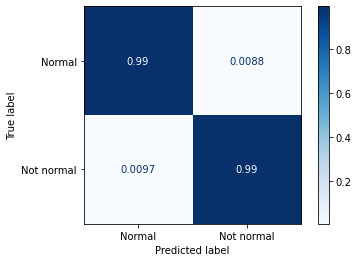

In [54]:
plot_confusion_matrix(rf, X_val, y_val,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true');


# Final model training (full dataset)

- Combine train/validation data and retrain the model on the full trianing set, using the best parameters from GridSearchCV above

In [55]:
X = df[['acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
       'drifting_score', 'speeding_score', 'follow_score', 'speed_mph', 'road_type_dummy', 'night_dummy']]
y = df['class_normal_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
X_train.shape, y_train.shape

((24600, 10), (24600,))

In [57]:
X_test.shape, y_test.shape

((6151, 10), (6151,))

In [58]:
rf_final = RandomForestClassifier(n_estimators=150, max_features='sqrt',
                                  bootstrap=True, n_jobs=-1)

rf_final.fit(X_train, y_train)


RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1)

In [59]:
y_rf_final_pred = rf_final.predict(X_test)
y_rf_final_pred_prob = rf_final.predict_proba(X_test)[:, 1]

print('Test set scores:\n')
print(f'\tAccuracy:\t {accuracy_score(y_test, y_rf_final_pred):.4f}')
print(f'\tPrecision:\t {precision_score(y_test, y_rf_final_pred):.4f}')
print(f'\tRecall:\t\t {recall_score(y_test, y_rf_final_pred):.4f}')
print(f'\tF1:\t\t {f1_score(y_test, y_rf_final_pred):.4f}')
print(f'\tFbeta (beta=2):\t {fbeta_score(y_test, y_rf_final_pred, beta=2):.4f}')
print(f'\tAUC:\t\t {roc_auc_score(y_test, y_rf_final_pred):.4f}')


Test set scores:

	Accuracy:	 0.9927
	Precision:	 0.9958
	Recall:		 0.9916
	F1:		 0.9937
	Fbeta (beta=2):	 0.9925
	AUC:		 0.9929


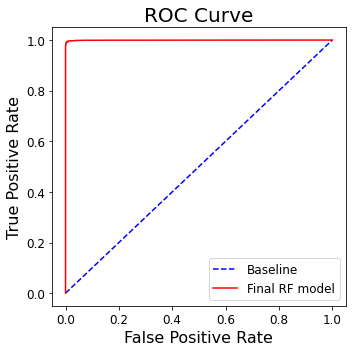

In [74]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_rf_final_pred_prob)

fig, ax = plt.subplots(figsize=(5,5))
ax.tick_params(labelsize=12)

ax.plot(base_fpr, base_tpr, 'b--', label = 'Baseline')
ax.plot(model_fpr, model_tpr, 'r', label = 'Final RF model')

ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)

ax.set_title('ROC Curve', fontsize=20)

ax.legend(fontsize=12)

fig.tight_layout()

fig.savefig('figures/roc_curve_final.png', dpi=300)


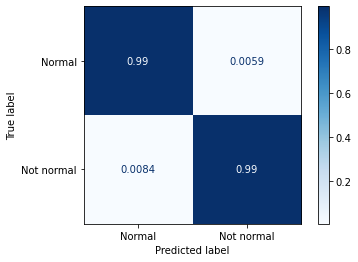

In [61]:
plot_confusion_matrix(rf_final, X_test, y_test,
                      display_labels=['Normal', 'Not normal'],
                      cmap=plt.cm.Blues,
                      normalize='true');


In [62]:
importance = rf_final.feature_importances_
importance_std = np.std([tree.feature_importances_ for tree in rf_final.estimators_], axis=0)
features = np.array(['acceleration', 'braking', 'turning', 'weaving',
            'drifting', 'speeding', 'follow', 'speed (mph)', 'road type', 'day-night'])

d = {'feature':features, 'importance':importance, 'importance_std':importance_std}
importance_df = pd.DataFrame(data=d)
importance_df.sort_values(['importance'], ascending=True, inplace=True)


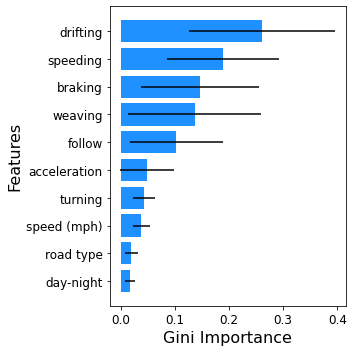

In [65]:
fig, ax = plt.subplots(figsize=(5,5))
ax.tick_params(labelsize=12)

ax.barh(y=importance_df['feature'], width=importance_df['importance'], xerr=importance_df['importance_std'], color='dodgerblue')
ax.set_xlabel('Gini Importance', fontsize=16)
ax.set_ylabel('Features', fontsize=16)
fig.tight_layout()

fig.savefig('figures/feature_importance_errors.png', dpi=300)


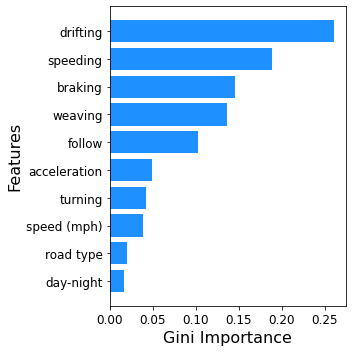

In [66]:
fig, ax = plt.subplots(figsize=(5,5))
ax.tick_params(labelsize=12)

ax.barh(y=importance_df['feature'], width=importance_df['importance'], color='dodgerblue')
ax.set_xlabel('Gini Importance', fontsize=16)
ax.set_ylabel('Features', fontsize=16)
fig.tight_layout()

fig.savefig('figures/feature_importance.png', dpi=300)

In [64]:
import os
import pickle

if not os.path.exists(os.path.dirname('models/')):
    os.makedirs(os.path.dirname('models/'))
    
with open('models/rf_final.pickle', 'wb+') as pfile:
        pickle.dump(rf_final, pfile)
        